In [1]:
print("Kernel check...")

Kernel check...


# My First CNN – Tomato Leaf Disease Classification

Goal:
- Understand how CNNs work
- Build a simple CNN from scratch
- Train on tomato leaf images
- Observe behavior (not optimize accuracy)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from pathlib import Path


Why transforms?

- CNNs expect same-sized images
- Images must be converted to numbers (tensors)
- Scaling pixel values helps learning


In [6]:
transform=transforms.Compose([
    transforms.Resize((128,128)), # smaller for first cnn
    transforms.ToTensor()  # converts to [0,1] tensor
])

In [9]:
DATA_DIR=Path("../data/processed")

train_dataset=datasets.ImageFolder(DATA_DIR / "train",transform=transform)
val_dataset=datasets.ImageFolder(DATA_DIR / "val",transform=transform)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

num_classes=len(train_dataset.classes)
num_classes,train_dataset.classes

(10,
 ['Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_Leaf_Mold',
  'Tomato_Septoria_leaf_spot',
  'Tomato_Spider_mites',
  'Tomato_Target_Spot',
  'Tomato_Tomato_YellowLeaf_Curl_Virus',
  'Tomato_Tomato_mosaic_virus',
  'Tomato_healthy'])

In [10]:
images,labels=next(iter(train_loader))

images.shape,labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

### CNN model

In [14]:
class SimpleCNN(nn.Module):

    def __init__(self,num_classes):
        super().__init__()

        self.features=nn.Sequential(

            nn.Conv2d(3,16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier=nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(32*32*32,128),
            nn.ReLU(),
            nn.Linear(128,num_classes),
        )


    def forward(self,x):
        x=self.features(x)
        x=self.classifier(x)
        return x


In [15]:
device='cuda' if torch.cuda.is_available() else "cpu"
print(device)



cpu


In [16]:
model=SimpleCNN(num_classes).to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [19]:
num_epochs=10

train_losses=[]
val_accuracies=[]

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images,labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss +=loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    correct=0
    total=0


    with torch.no_grad():
        for images, labels in val_loader:
            images,labels= images.to(device),labels.to(device)
            outputs= model(images)
            preds=outputs.argmax(dim=1)

            correct += (preds==labels).sum().item()
            total += labels.size(0)

    val_acc=correct/total
    val_accuracies.append(val_acc)


    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch [1/10] Train Loss: 0.6532 | Val Acc: 0.7871
Epoch [2/10] Train Loss: 0.4489 | Val Acc: 0.8271
Epoch [3/10] Train Loss: 0.3214 | Val Acc: 0.8452
Epoch [4/10] Train Loss: 0.2361 | Val Acc: 0.8399
Epoch [5/10] Train Loss: 0.1751 | Val Acc: 0.8615
Epoch [6/10] Train Loss: 0.1238 | Val Acc: 0.8743
Epoch [7/10] Train Loss: 0.0936 | Val Acc: 0.8821
Epoch [8/10] Train Loss: 0.0617 | Val Acc: 0.8474
Epoch [9/10] Train Loss: 0.0517 | Val Acc: 0.8721
Epoch [10/10] Train Loss: 0.0403 | Val Acc: 0.8906


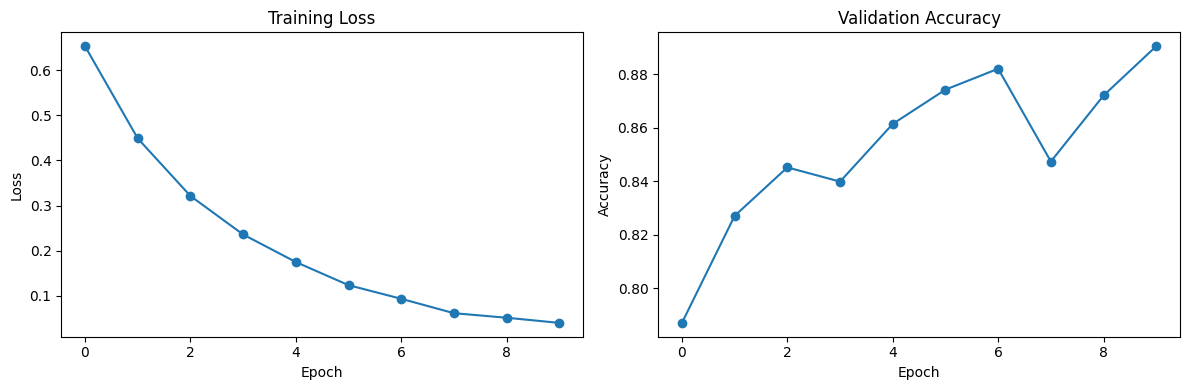

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses,marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
